In [191]:
import ee
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

ee.Authenticate()
ee.Initialize(project="biodiversitymeetsdata")

# Functions

In [192]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['longitude', 'latitude','time','datetime',  *list_of_bands]]

    return df

def extractRow(featureRow, bands):
    """
    Extracts all relevant information from a pixel contained within the JSON object
    
    Args:
        featureRow (dict): A dictionary which is part of the jsonObj["features"] list
        bands (list): A list containing the bands of interest that are selected from the Image instance
        
    Returns:
        valueDict (dict): A dictionary where the longitude, latitude and bands are mapped to their corresponding 
                          values in the json object from the sampleRegions function
    """
    featureKeys=["longitude", "latitude", *bands]
    values = list(itertools.chain([featureRow["geometry"]["coordinates"][0], featureRow["geometry"]["coordinates"][1]],
                                      [featureRow["properties"][key] for key in bands]))
    return dict(zip(featureKeys, values))

import pandas as pd

def jsonToDf(jsonObj, bands):
    data=[extractRow(featureRow, bands) for featureRow in jsonObj["features"]]
    return pd.DataFrame(data)

In [193]:
def bbox_to_rect(bbox_dict):
    return ee.Geometry.Rectangle([
        bbox_dict["west"], bbox_dict["south"],
        bbox_dict["east"], bbox_dict["north"]
    ])

In [194]:
def sampleImage(img, bands, geomObj, scale):
    #Select the bands of interest from the image
    imgBands = img.select(*bands)
    return imgBands.sampleRegions(collection=ee.FeatureCollection([geomObj]),
                                  scale=scale,
                                  geometries=True).getInfo()

def sampleIC(IC, bands, geomObj, scale):
    #Select the bands of interest from the image collection
    IC=IC.select(*bands)
    return IC.getRegion(geomObj, scale=scale).getInfo()

In [195]:
class_labels = {
    10: "Tree cover",
    20: "Schrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built up",
    60: "Bare / sparse vegetation",
    70: "Snow and ice",
    80: "Permanent Water Bodies",
    90: "Herbaceous wetland",
    95: "Man groves",
    100: "Moss and lichen"
}

class_colors = {
10:"#006400",#Tree cover
20:"#ffbb22",#Shrubland
30:"#ffff4c",#Grassland
40:"#f096ff",#Cropland
50:"#fa0000",#Built-up
60:"#b4b4b4",#Bare / sparse vegetation
70:"#f0f0f0",#Snow and ice
80:"#0064c8",#Permanent water bodies
90:"#0096a0",#Herbaceous wetland
95:"#00cf75",#Mangroves
100:"#fae6a0"#Moss and lichen
}

def visualiseWorldCover(df):
    colors = [class_colors[label] for label in df["Map"]]
    plt.scatter(df['longitude'], df['latitude'], c=colors, s=5, alpha=0.7)
    for label, color in class_colors.items():
        plt.scatter([], [], c=color, label=f'{class_labels[label]}', s=50)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Shared variables

In [196]:
# bounding boxes
meiseSpatial = {"west": 4.312323, "south": 50.922796, "east": 4.335497, "north": 50.934860}
bxlSpatial = {"west": 4.264069, "south": 50.696458, "east": 4.984360, "north": 50.940258}
belgiumSpatial = {"west": 2.537842, "south": 49.500242, "east": 6.388550, "north": 51.515580}
europeSpatial = {"west": -23.203125, "south": 34.452218, "east": 30.937500, "north": 71.074056}

# Convert to ee.Geometry.Rectangle
meise_roi = bbox_to_rect(meiseSpatial)
bxl_roi = bbox_to_rect(bxlSpatial)
belgium_roi = bbox_to_rect(belgiumSpatial)
europe_roi = bbox_to_rect(europeSpatial)

# ESA World Cover

In [34]:
ic = ee.ImageCollection('ESA/WorldCover/v200')

In [41]:
sampledImg = sampleIC(ic, ["Map"], belgium_roi, 400)

In [42]:
sampledImg

[['id', 'longitude', 'latitude', 'time', 'Map'],
 ['2021', 6.218138396675328, 49.50256204669035, 1609455600000, 30],
 ['2021', 6.221731657811806, 49.50256204669035, 1609455600000, 30],
 ['2021', 6.225324918948284, 49.50256204669035, 1609455600000, 10],
 ['2021', 6.228918180084762, 49.50256204669035, 1609455600000, 30],
 ['2021', 6.232511441221241, 49.50256204669035, 1609455600000, 30],
 ['2021', 6.236104702357719, 49.50256204669035, 1609455600000, 30],
 ['2021', 6.239697963494197, 49.50256204669035, 1609455600000, 30],
 ['2021', 6.243291224630675, 49.50256204669035, 1609455600000, 40],
 ['2021', 6.246884485767152, 49.50256204669035, 1609455600000, 40],
 ['2021', 6.250477746903631, 49.50256204669035, 1609455600000, 40],
 ['2021', 6.254071008040109, 49.50256204669035, 1609455600000, 40],
 ['2021', 6.257664269176587, 49.50256204669035, 1609455600000, 10],
 ['2021', 6.261257530313065, 49.50256204669035, 1609455600000, 10],
 ['2021', 6.264850791449543, 49.50256204669035, 1609455600000, 10],

## Meise

In [190]:
worldCoverMeise = dataset.getRegion(meise_roi, scale=10).getInfo()
worldCoverMeise

[['id', 'longitude', 'latitude', 'time', 'Map'],
 ['2020', 4.312407437179969, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.3124972687083805, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.312587100236793, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.312676931765204, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.312766763293617, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.312856594822029, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.3129464263504405, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.313036257878853, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.313126089407264, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.313215920935677, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.313305752464088, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.3133955839925004, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.313485415520912, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.313575247049324, 50.92284342664752, 1577836800000, 1

In [191]:
mapMeise = ee_array_to_df(worldCoverMeise, ["Map"])

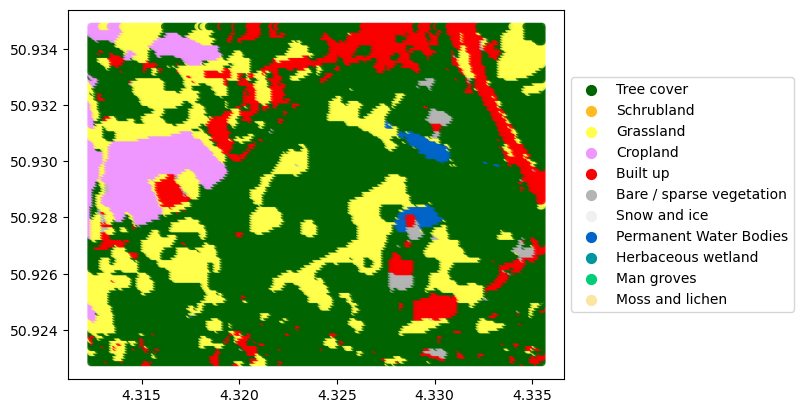

In [192]:
visualiseWorldCover(mapMeise)

## Brussels

In [196]:
worldCoverBxl = dataset.getRegion(bxl_roi, scale=100).getInfo()
worldCoverBxl

[['id', 'longitude', 'latitude', 'time', 'Map'],
 ['2020', 4.264751811357429, 50.69687221692726, 1577836800000, 10],
 ['2020', 4.265650126641548, 50.69687221692726, 1577836800000, 50],
 ['2020', 4.266548441925668, 50.69687221692726, 1577836800000, 50],
 ['2020', 4.267446757209787, 50.69687221692726, 1577836800000, 30],
 ['2020', 4.268345072493907, 50.69687221692726, 1577836800000, 40],
 ['2020', 4.269243387778026, 50.69687221692726, 1577836800000, 40],
 ['2020', 4.270141703062146, 50.69687221692726, 1577836800000, 40],
 ['2020', 4.271040018346265, 50.69687221692726, 1577836800000, 40],
 ['2020', 4.271938333630385, 50.69687221692726, 1577836800000, 40],
 ['2020', 4.272836648914504, 50.69687221692726, 1577836800000, 40],
 ['2020', 4.273734964198623, 50.69687221692726, 1577836800000, 40],
 ['2020', 4.274633279482743, 50.69687221692726, 1577836800000, 40],
 ['2020', 4.275531594766862, 50.69687221692726, 1577836800000, 30],
 ['2020', 4.276429910050982, 50.69687221692726, 1577836800000, 50],

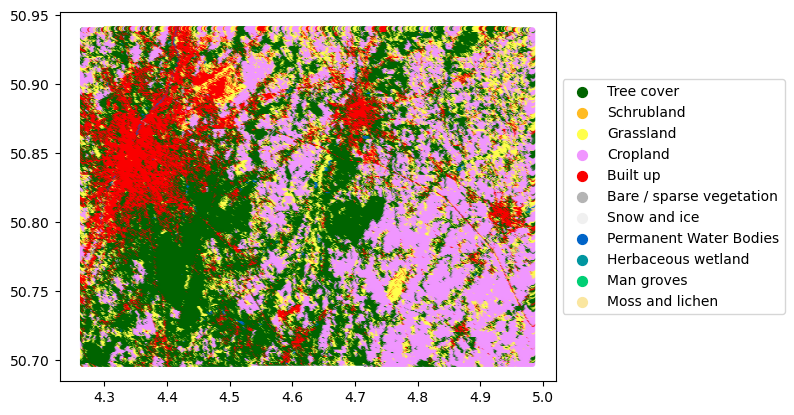

In [199]:
mapBxl = ee_array_to_df(worldCoverBxl, ["Map"])
visualiseWorldCover(mapBxl)

## Belgium

In [207]:
worldCoverBE = dataset.getRegion(belgium_roi, scale=500).getInfo()
worldCoverBE 

[['id', 'longitude', 'latitude', 'time', 'Map'],
 ['2020', 2.539986465847947, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.544478042268545, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.548969618689142, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.55346119510974, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.5579527715303376, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.5624443479509353, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.5669359243715326, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.5714275007921303, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.575919077212728, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.580410653633326, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.584902230053923, 49.503909519616535, 1577836800000, 10],
 ['2020', 2.5893938064745208, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.5938853828951185, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.598376959315716, 49.503909519616535, 

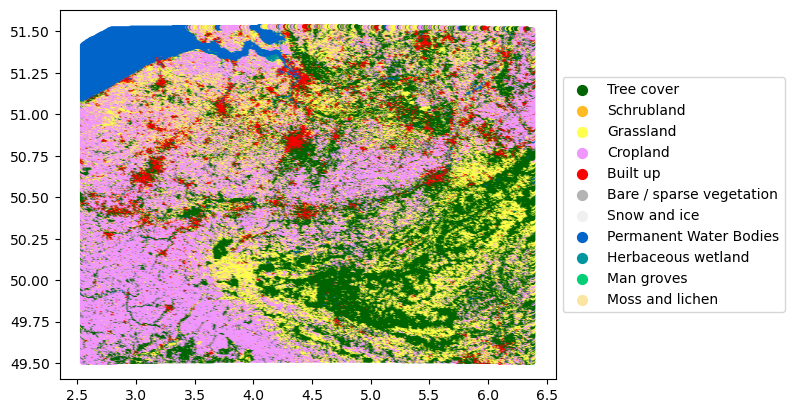

In [208]:
mapBE = ee_array_to_df(worldCoverBE, ["Map"])
visualiseWorldCover(mapBE)

## Europe

In [213]:
worldCoverEU = dataset.getRegion(europe_roi, scale=5000).getInfo()
worldCoverEU 

[['id', 'longitude', 'latitude', 'time', 'Map'],
 ['2020', 30.87958789160855, 34.472849028086635, 1577836800000, None],
 ['2020', 30.924503655814526, 34.472849028086635, 1577836800000, None],
 ['2020', 30.65500907057867, 34.51776479229261, 1577836800000, None],
 ['2020', 30.699924834784646, 34.51776479229261, 1577836800000, None],
 ['2020', 30.74484059899062, 34.51776479229261, 1577836800000, None],
 ['2020', 30.7897563631966, 34.51776479229261, 1577836800000, None],
 ['2020', 30.834672127402573, 34.51776479229261, 1577836800000, None],
 ['2020', 30.87958789160855, 34.51776479229261, 1577836800000, None],
 ['2020', 30.924503655814526, 34.51776479229261, 1577836800000, None],
 ['2020', 30.475346013754766, 34.56268055649859, 1577836800000, None],
 ['2020', 30.52026177796074, 34.56268055649859, 1577836800000, None],
 ['2020', 30.56517754216672, 34.56268055649859, 1577836800000, None],
 ['2020', 30.610093306372693, 34.56268055649859, 1577836800000, None],
 ['2020', 30.65500907057867, 34.56

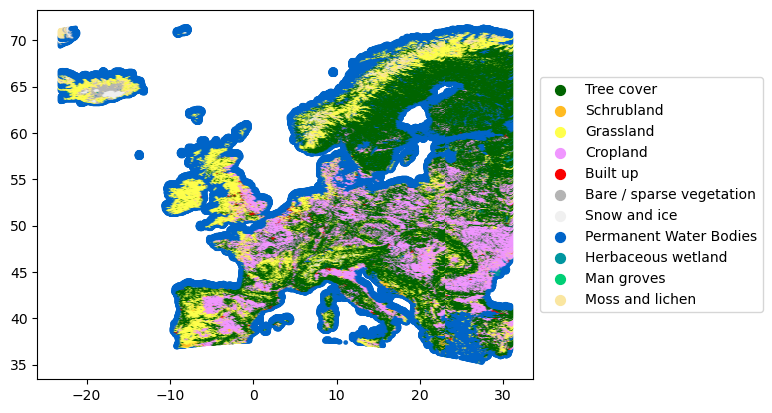

In [214]:
mapEU = ee_array_to_df(worldCoverEU, ["Map"])
visualiseWorldCover(mapEU)

# Elevation

In [86]:
# Import the USGS ground elevation image.
elevation = ee.Image('USGS/SRTMGL1_003')

## Meise

In [9]:
elevationMeise = sampleImage(elevation, ["elevation"], meise_roi, 30)
elevationMeise = jsonToDf(elevationMeise, ["elevation"])

In [19]:
elevationMeise

longitude   latitude  elevation
0      4.312463  50.934745         67
1      4.312733  50.934745         66
2      4.313002  50.934745         66
3      4.313272  50.934745         66
4      4.313541  50.934745         65
...         ...        ...        ...
3865   4.334292  50.922888         43
3866   4.334562  50.922888         43
3867   4.334831  50.922888         41
3868   4.335101  50.922888         39
3869   4.335370  50.922888         39

[3870 rows x 3 columns]

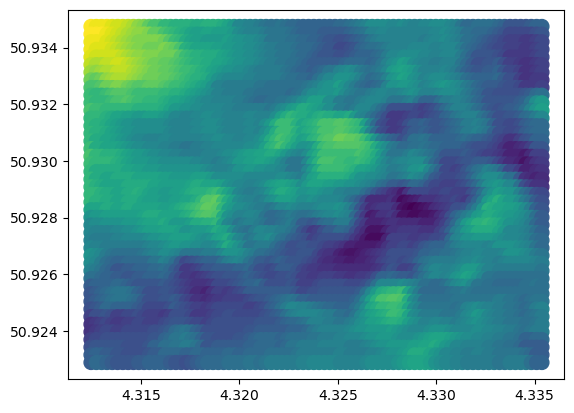

In [20]:
plt.scatter(elevationMeise["longitude"], elevationMeise["latitude"], c=elevationMeise["elevation"], cmap="viridis", s=100)

## Brussels

In [43]:
elevationBxl = sampleImage(elevation, ["elevation"], bxl_roi, 750)
elevationBxl = jsonToDf(elevationBxl, ["elevation"])

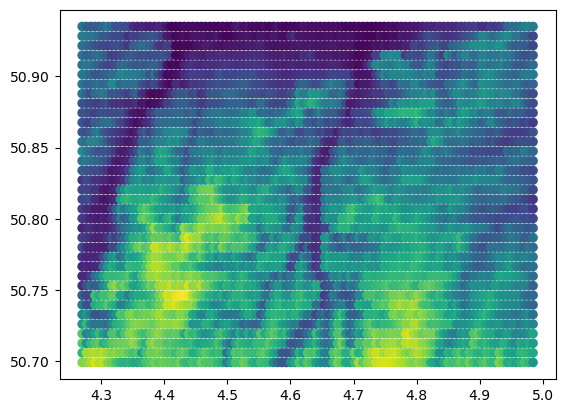

In [83]:
plt.scatter(elevationBxl["longitude"], elevationBxl["latitude"], c=elevationBxl["elevation"], cmap="viridis", s=35)

In [63]:
xi = np.linspace(elevationBxl['longitude'].min(), elevationBxl['longitude'].max(), 200)
yi = np.linspace(elevationBxl['latitude'].min(), elevationBxl['latitude'].max(), 200)
xi, yi = np.meshgrid(xi, yi) 
zi = griddata((elevationBxl['longitude'], elevationBxl['latitude']), 
              elevationBxl['elevation'],
              (xi,yi),
              method="cubic")

C:\Users\niels\AppData\Local\Temp\ipykernel_34252\1149446952.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


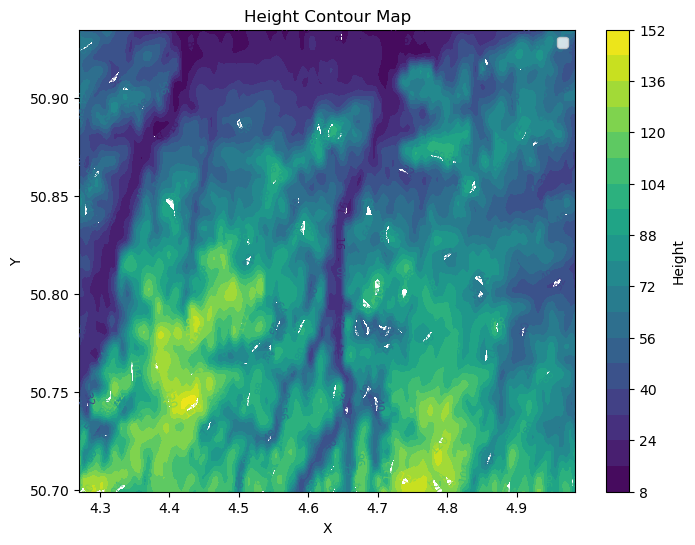

In [64]:
plt.figure(figsize=(8, 6))
contour = plt.contourf(xi, yi, zi, levels=20, cmap='viridis')
plt.clabel(contour, inline=True, fontsize=8)
#plt.scatter(elevationBxl['longitude'], elevationBxl['latitude'], c='red', s=20, label='Data Points')
plt.colorbar(label='Height')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Height Contour Map')
plt.legend()

C:\Users\niels\AppData\Local\Temp\ipykernel_34252\3393902145.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


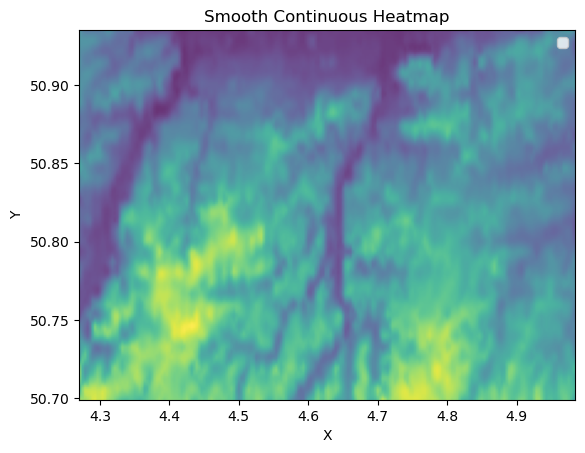

In [77]:
#plt.figure(figsize=(10, 15))
plt.imshow(zi, extent=(xi.min(), xi.max(), yi.min(), yi.max()), origin='lower',
                    cmap='viridis', alpha=0.8, aspect='auto')
#plt.colorbar(label='Height')
#plt.scatter(elevationBxl['longitude'], elevationBxl['latitude'], c='black', s=2, label='Data Points')  # Optional
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Smooth Continuous Heatmap')
plt.legend()
plt.show()

## Belgium

In [97]:
elevationBE = sampleImage(elevation, ["elevation"], belgium_roi, scale=5000)
elevationBE = jsonToDf(elevationBE, ["elevation"])

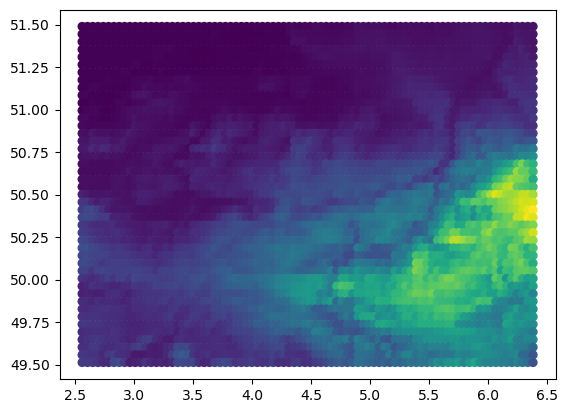

In [104]:
plt.scatter(elevationBE["longitude"], elevationBE["latitude"], c=elevationBE["elevation"], cmap="viridis", s=32)

C:\Users\niels\AppData\Local\Temp\ipykernel_34252\283637424.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


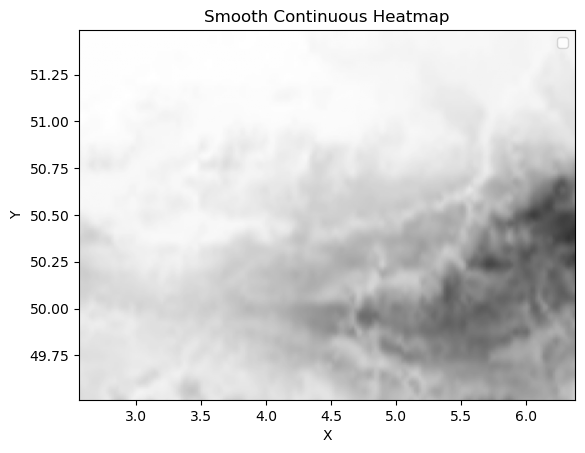

In [102]:
xi = np.linspace(elevationBE['longitude'].min(), elevationBE['longitude'].max(), 200)
yi = np.linspace(elevationBE['latitude'].min(), elevationBE['latitude'].max(), 200)
xi, yi = np.meshgrid(xi, yi) 
zi = griddata((elevationBE['longitude'], elevationBE['latitude']), 
              elevationBE['elevation'],
              (xi,yi),
              method="cubic")

#plt.figure(figsize=(10, 15))
plt.imshow(zi, extent=(xi.min(), xi.max(), yi.min(), yi.max()), origin='lower',
                    cmap='gray_r', alpha=0.8, aspect='auto')
#plt.colorbar(label='Height')
#plt.scatter(elevationBxl['longitude'], elevationBxl['latitude'], c='black', s=2, label='Data Points')  # Optional
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Smooth Continuous Heatmap')
plt.legend()
plt.show()

## Temperature map

### MODIS

In [212]:
lst = ee.ImageCollection('MODIS/006/MOD11A1')
lst = lst.filterDate("2019-06-01", "2019-06-03")

In [213]:
lst = sampleIC(lst, ["LST_Day_1km"], belgium_roi, 1000)

In [214]:
lstDF = pd.DataFrame(data=lst[1:], columns=lst[0])

In [227]:
lstDF

id  longitude   latitude           time  LST_Day_1km
0       2019_06_01   2.546724  49.501664  1559347200000       300.08
1       2019_06_02   2.546724  49.501664  1559433600000       301.52
2       2019_06_01   2.555707  49.501664  1559347200000       300.52
3       2019_06_02   2.555707  49.501664  1559433600000       301.66
4       2019_06_01   2.564690  49.501664  1559347200000       300.52
...            ...        ...        ...            ...          ...
191975  2019_06_02   5.475232  51.522873  1559433600000          NaN
191976  2019_06_01   5.484215  51.522873  1559347200000       298.92
191977  2019_06_02   5.484215  51.522873  1559433600000          NaN
191978  2019_06_01   5.493198  51.522873  1559347200000       298.92
191979  2019_06_02   5.493198  51.522873  1559433600000          NaN

[191980 rows x 5 columns]

In [215]:
lstDF["LST_Day_1km"] = lstDF["LST_Day_1km"]*0.02

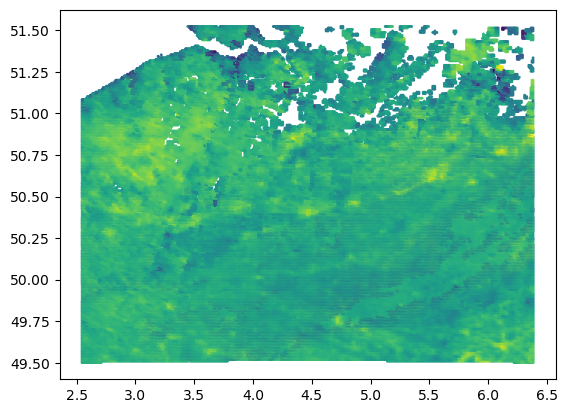

In [220]:
plt.scatter(lstDF["longitude"], lstDF["latitude"], c=lstDF["LST_Day_1km"], s=1)

## Soil map

### Soil composition

In [259]:
clay = ee.Image("OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02")
sand = ee.Image("OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02")
organicMatter = ee.Image("OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02")

#bands=["b0", "b10", "b30", "b60", "b100", "b200"]
bands=["b0"]

In [258]:
clayBE = sampleImage(clay, ["b0"], belgium_roi, 4750)
sandBE = sampleImage(sand, ["b0"], belgium_roi, 4750)
omBE = sampleImage(organicMatter, ["b0"], belgium_roi, 4750)

In [260]:
clayBE_df = jsonToDf(clayBE, bands)
sandBE_df = jsonToDf(sandBE, bands)
omBE_df = jsonToDf(omBE, bands)

In [285]:
np.histogram(omBE_df["b0"])

(array([ 290, 2285,  689,  653,  129,   91,   34,   11,    5,    3]),
 array([ 0. ,  2.6,  5.2,  7.8, 10.4, 13. , 15.6, 18.2, 20.8, 23.4, 26. ]))

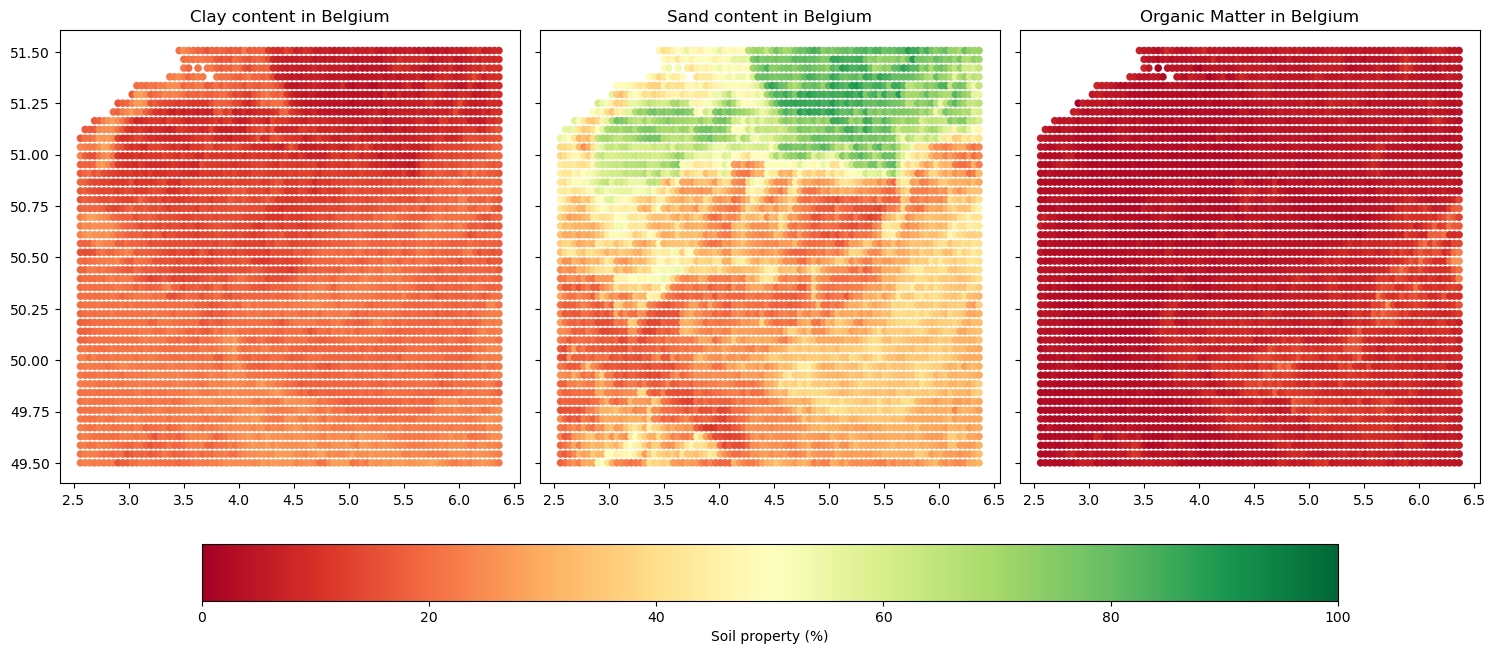

In [298]:
fig, axes = plt.subplots(1, 3, figsize=(15,8), sharex=True, sharey=True)

titles = ["Clay content in Belgium", "Sand content in Belgium", "Organic Matter in Belgium"]

for ax, title, df in zip(axes.flatten(), titles, [clayBE_df, sandBE_df, omBE_df]):
    sc=ax.scatter(df["longitude"], df["latitude"], c=df["b0"], s=20, cmap='RdYlGn', vmin=0, vmax=100)
    ax.set_title(title)

plt.tight_layout()
fig.subplots_adjust(bottom=0.2) 
    
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), orientation='horizontal', shrink=0.8, pad=0.1)
cbar.set_label("Soil property (%)")

plt.show()
#plt.scatter(clayBE_b0_df["longitude"], clayBE_b0_df["latitude"], c=clayBE_b0_df["b0"], s=20)

#### Soil density and texture

In [ ]:
soilbulkDensity =
soilTexture =

#### Sand

In [251]:
sand = ee.Image("OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02")

In [252]:
sandBE = sampleImage(sand, ["b0", "b10", "b30", "b60", "b100", "b200"], belgium_roi, 5000)

In [253]:
sandBE_df = jsonToDf(sandBE, bands)

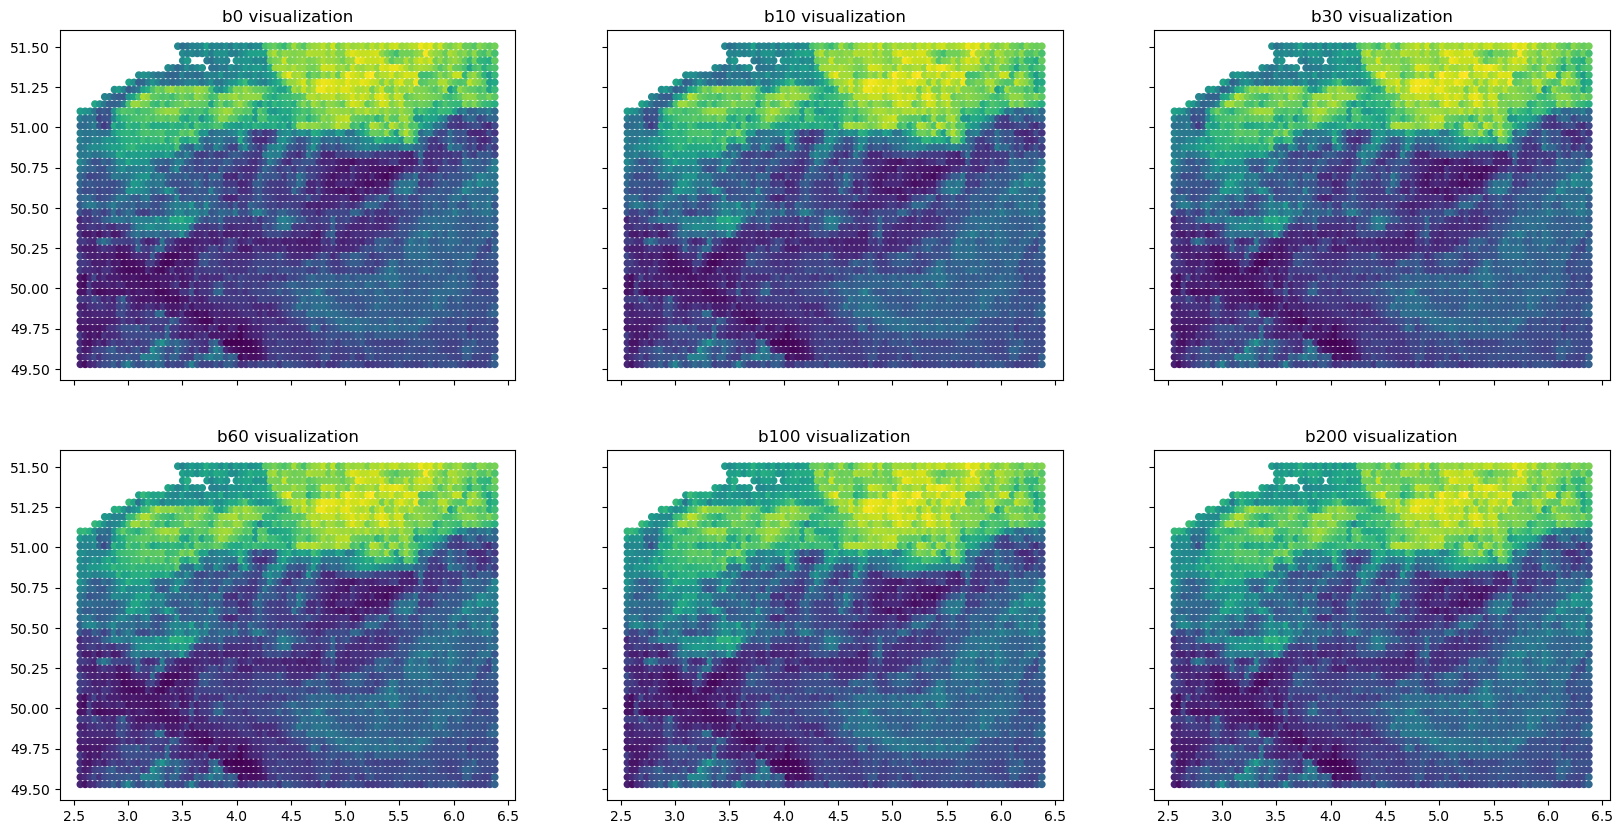

In [254]:
fig, axes = plt.subplots(2, 3, figsize=(20,10), sharex=True, sharey=True)

for ax, band in zip(axes.flatten(), bands):
    ax.scatter(sandBE_df["longitude"], sandBE_df["latitude"], c=sandBE_df[band], s=20)
    ax.set_title(band+" visualization")

plt.show()

### Ground Water

https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V021_NOAH_G025_T3H

In [256]:
gw = ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H")

## Pollution map

In [301]:
co = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CO").filterDate("2020-06-01", "2020-06-02")
hcho = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_HCHO").filterDate("2020-06-01", "2020-06-02")
no2 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2").filterDate("2020-06-01", "2020-06-02")
so2 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_SO2").filterDate("2020-06-01", "2020-06-02")
o3 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_O3").filterDate("2020-06-01", "2020-06-02")
ch4 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CH4").filterDate("2020-06-01", "2020-06-02") 

In [318]:
coBE = sampleIC(co, ["CO_column_number_density"], belgium_roi, 5000)
hchoBE = sampleIC(hcho, ["tropospheric_HCHO_column_number_density"], belgium_roi, 5000)
no2BE = sampleIC(no2, ["NO2_column_number_density"], belgium_roi, 5000)
so2BE = sampleIC(so2, ["SO2_column_number_density"], belgium_roi, 5000)
o3BE = sampleIC(o3, ["O3_column_number_density"], belgium_roi, 5000)
ch4BE = sampleIC(ch4, ["CH4_column_volume_mixing_ratio_dry_air"], belgium_roi, 5000)

In [319]:
coBE_df = pd.DataFrame(data=coBE[1:], columns=coBE[0])
hchoBE_df = pd.DataFrame(data=hchoBE[1:], columns=hchoBE[0])
no2BE_df = pd.DataFrame(data=no2BE[1:], columns=no2BE[0])
so2BE_df = pd.DataFrame(data=so2BE[1:], columns=so2BE[0])
o3BE_df = pd.DataFrame(data=o3BE[1:], columns=o3BE[0])
ch4BE_df = pd.DataFrame(data=ch4BE[1:], columns=ch4BE[0])

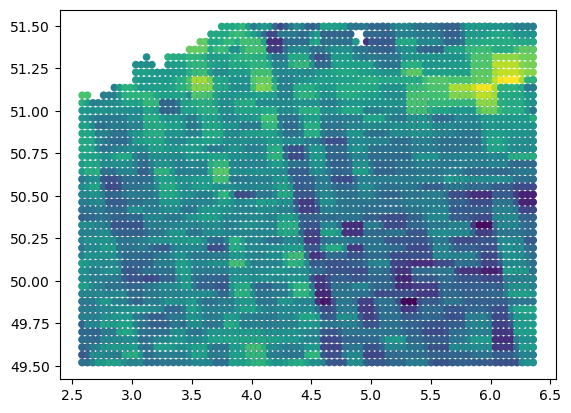

In [322]:
plt.scatter(coBE_df["longitude"],coBE_df["latitude"], c=coBE_df["CO_column_number_density"], s=20)

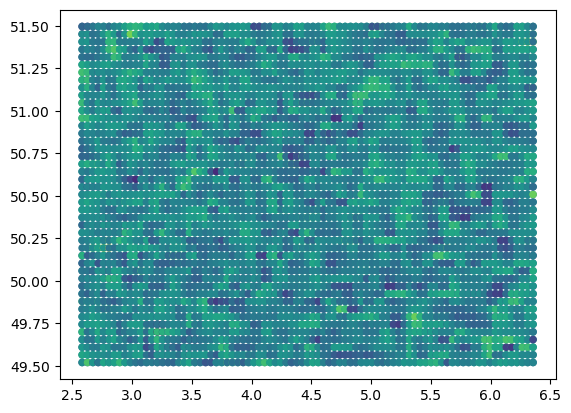

In [323]:
plt.scatter(hchoBE_df["longitude"],hchoBE_df["latitude"], c=hchoBE_df["tropospheric_HCHO_column_number_density"], s=20)

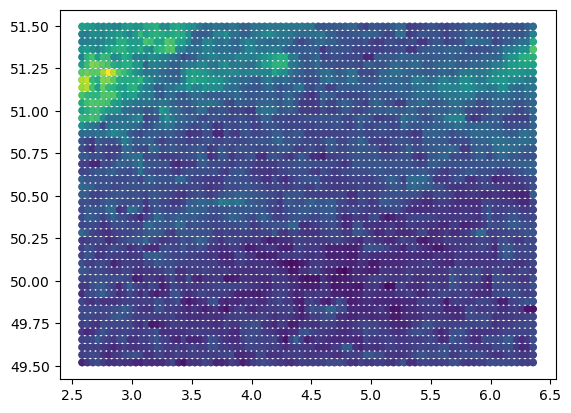

In [324]:
plt.scatter(no2BE_df["longitude"],no2BE_df["latitude"], c=no2BE_df["NO2_column_number_density"], s=20)

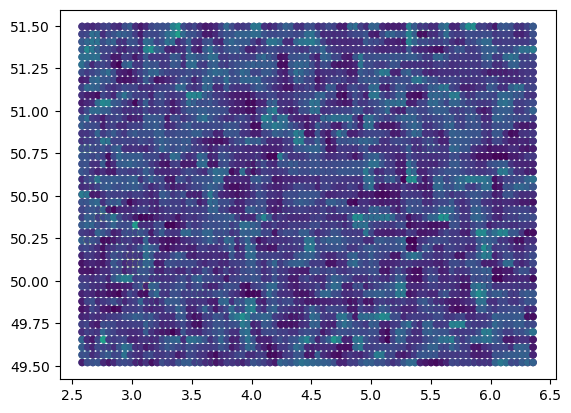

In [325]:
plt.scatter(so2BE_df["longitude"],so2BE_df["latitude"], c=so2BE_df["SO2_column_number_density"], s=20)

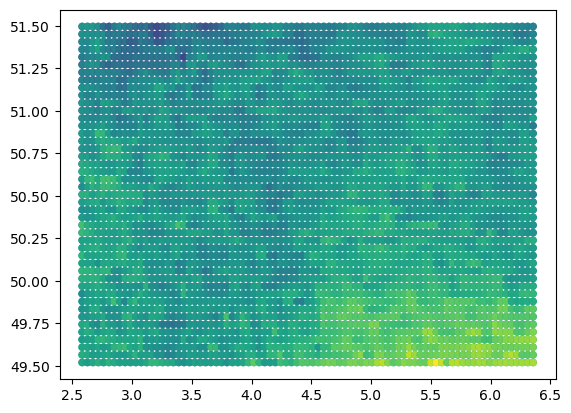

In [326]:
plt.scatter(o3BE_df["longitude"],o3BE_df["latitude"], c=o3BE_df["O3_column_number_density"], s=20)

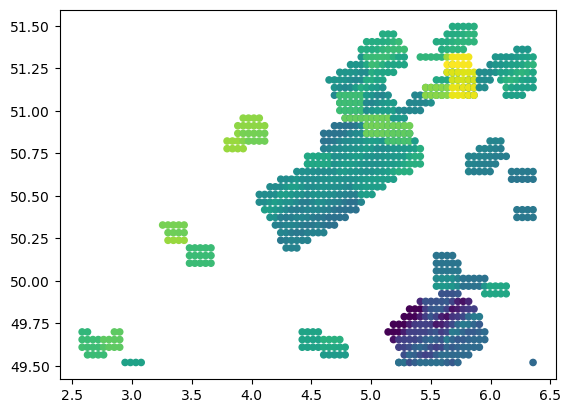

In [328]:
plt.scatter(ch4BE_df["longitude"],ch4BE_df["latitude"], c=ch4BE_df["CH4_column_volume_mixing_ratio_dry_air"], s=20)